In [1]:
%load_ext autoreload 
%autoreload 2 

In [92]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from src.utilities.pandas_helpers import filter_columns_by_search, flatten_dataframe

In [83]:
DATA_PATH = '/Users/mds8301/iterm_data_storage/full_dataset.parquet.gzip'
data = pd.read_parquet(DATA_PATH)
def calculate_max_min_signal(df):
    
    events = filter_columns_by_search(df, 'event')
    actions = filter_columns_by_search(df, 'action')
    mouse = filter_columns_by_search(df, 'mouse')
    sensors = filter_columns_by_search(df, 'sensor')
    sex = filter_columns_by_search(df, 'sex')
    return (
        df
        .groupby(by = mouse+events+actions+sensors+sex+['day', 'trial_count'], as_index = False).agg({"signal": ["max", "min"]})
        .pipe(flatten_dataframe)
        .rename(columns = lambda c: c.strip("_"))
        .drop(columns ='index')
    )

data = calculate_max_min_signal(data)

In [85]:
data.columns

Index(['mouse_id_0', 'mouse_id_1', 'mouse_id_2', 'mouse_id_3', 'mouse_id_4',
       'mouse_id_5', 'mouse_id_6', 'mouse_id_7', 'mouse_id_8', 'mouse_id_9',
       'mouse_id_10', 'mouse_id_11', 'mouse_id_12', 'mouse_id_13', 'event_cue',
       'event_escape', 'event_avoid', 'event_shock', 'action_escape',
       'action_avoid', 'sensor_D1', 'sensor_D2', 'sensor_DA', 'sex_M', 'day',
       'trial_count', 'signal_max', 'signal_min'],
      dtype='object')

In [84]:


def rehape_df(df):
    mouse_cols =  [col for col in data.columns if 'mouse' in col]
    sensor_cols = [col for col in data.columns if 'sensor' in col]
    event_cols = [col for col in data.columns if 'event' in col]
    actions_cols = [col for col in data.columns if 'action' in col]
    return (df
            .rename(columns = {'sex_M': 'sex'})
            .assign(sensor = lambda df_: df_[sensor_cols].idxmax(axis = 1).str.replace('sensor_', '').astype('category'),
                   event = lambda df_: df_[event_cols].idxmax(axis = 1).str.replace('event_', '').astype('category'),
                   mouse = lambda df_: df_[mouse_cols].idxmax(axis=1).str.replace('mouse_id_', '').astype('int'),
                   action = lambda df_: df_[actions_cols].idxmax(axis=1).str.replace('action_', '').replace({'avoid': 0, 'escape': 1}).astype('int'),
                   sex = lambda df_: df_.sex.replace({1: 'M', 0: 'F'}).astype('category')
                   
            )
            .drop(columns = mouse_cols + sensor_cols + event_cols + actions_cols)
    )

reshape_df = rehape_df(data)
reshape_df



,sex,day,trial_count,signal_max,signal_min,sensor,event,mouse,action
0,M,1,11,3.667982,-1.499421,DA,shock,13,0
1,M,1,13,4.060444,-1.642330,DA,shock,13,0
2,M,2,32,3.232928,-1.909482,DA,shock,13,0
3,M,2,36,3.125207,-1.720359,DA,shock,13,0
4,M,2,38,4.634110,-1.506546,DA,shock,13,0
...,...,...,...,...,...,...,...,...,...
12790,F,6,155,2.849145,-2.237678,D1,cue,0,1
12791,F,6,156,1.857814,-2.407810,D1,cue,0,1
12792,F,6,163,3.332467,-1.813297,D1,cue,0,1
12793,F,6,171,3.432094,-1.360054,D1,cue,0,1


In [86]:

X = reshape_df.drop(columns = 'action')
y = reshape_df['action']
stratify_cols = ['mouse', 'sex']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=reshape_df[stratify_cols])
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=X_temp[stratify_cols])
X_train

,sex,day,trial_count,signal_max,signal_min,sensor,event,mouse
4988,M,2,31,3.223194,-1.788068,DA,escape,8
2060,M,7,189,1.604421,-0.670402,D2,shock,11
4828,M,4,108,2.444597,-1.474923,D2,avoid,8
7731,M,4,114,3.250775,-1.778479,DA,cue,5
7570,M,1,5,4.617420,-1.708053,DA,escape,5
...,...,...,...,...,...,...,...,...
1107,F,6,149,2.962732,-3.293555,DA,avoid,12
11867,F,2,32,3.668425,-3.050101,DA,shock,0
10179,F,6,153,3.249433,-1.409212,D1,avoid,2
5914,M,1,24,2.995865,-2.336544,D2,escape,7


In [96]:

# num preprocessor

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
    ])
# cat preprocessor
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))    
])
num_features = X_train.select_dtypes("number").columns.to_list()
cat_features = X_train.select_dtypes("category").columns.to_list()

# column transformer
preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
    ])
# pipeline

preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['day', 'trial_count', 'signal_max',
                                  'signal_min', 'mouse']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['sex', 'sensor', 'event'])])

In [99]:
X_train_processed = preprocessor.transform(X_train)
X_dev_processed = preprocessor.transform(X_dev)
X_test_processed = preprocessor.transform(X_test)

In [105]:
import tensorflow as tf
from src.models.BaseClassifier import BaseClassifier
model = BaseClassifier(
    number_of_layers=3, 
    number_of_units=10,
    dropout_rate=0.2)

metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc-roc')]
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
                   loss=tf.keras.losses.BinaryCrossentropy(),
                   metrics=metrics)
model.fit(X_train_processed, y_train,
          epochs=100 , batch_size=64, 
          validation_data=(X_dev_processed, y_dev))

Epoch 1/100
160/160 [==============================] - 3s 15ms/step - loss: 0.7884 - accuracy: 0.4296 - precision: 0.2307 - recall: 0.1367 - auc-roc: 0.2996 - val_loss: 0.7189 - val_accuracy: 0.5121 - val_precision: 0.3081 - val_recall: 0.0950 - val_auc-roc: 0.4203
Epoch 2/100
160/160 [==============================] - 2s 11ms/step - loss: 0.6806 - accuracy: 0.5740 - precision: 0.5212 - recall: 0.1832 - auc-roc: 0.5665 - val_loss: 0.6518 - val_accuracy: 0.6278 - val_precision: 0.6864 - val_recall: 0.2706 - val_auc-roc: 0.6636
Epoch 3/100
160/160 [==============================] - 2s 10ms/step - loss: 0.6297 - accuracy: 0.6595 - precision: 0.6912 - recall: 0.3847 - auc-roc: 0.7024 - val_loss: 0.6231 - val_accuracy: 0.6685 - val_precision: 0.7094 - val_recall: 0.4068 - val_auc-roc: 0.7150
Epoch 4/100
160/160 [==============================] - 2s 10ms/step - loss: 0.6062 - accuracy: 0.6919 - precision: 0.7100 - recall: 0.4861 - auc-roc: 0.7354 - val_loss: 0.6096 - val_accuracy: 0.6919 - v

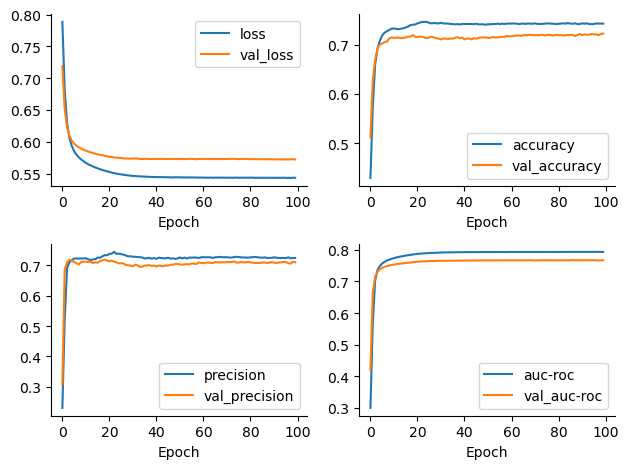

In [106]:
fig, ax = plt.subplots(2,2)
    
def plot_metrics(*metrics, model, title, ax):
    for metric in metrics:
        ax.plot(model.history.history[f'{metric}'], label=f'{metric}')
        ax.set_xlabel('Epoch')
        ax.legend() 
        sns.despine()

plot_metrics('loss', 'val_loss', model = model, title = 'Loss', ax = ax[0,0])
plot_metrics('accuracy', 'val_accuracy', model = model, title = 'Accuracy', ax = ax[0,1])
plot_metrics('precision', 'val_precision', model = model, title = 'Precision', ax = ax[1,0])
plot_metrics('auc-roc', 'val_auc-roc', model = model, title = 'Recall', ax = ax[1,1])
plt.tight_layout()

In [107]:
evalulation = model.evaluate(X_test_processed, y_test)
for name, value in zip(model.metrics_names, evalulation):
    print(f'{name}: {value}')

40/40 [==============================] - 1s 11ms/step - loss: 0.5559 - accuracy: 0.7375 - precision: 0.7458 - recall: 0.6633 - auc-roc: 0.7896
loss: 0.5559357404708862
accuracy: 0.737500011920929
precision: 0.7457627058029175
recall: 0.6633166074752808
auc-roc: 0.7895541191101074


In [132]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['day', 'trial_count', 'signal_max',
                                  'signal_min', 'mouse']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['sex', 'sensor', 'event'])])

In [140]:
cat_names = preprocessor.named_transformers_['cat'].named_steps["ohe"].get_feature_names_out().tolist()
columns = num_features + cat_names
columns
X_test_df = pd.DataFrame(X_test_processed, columns=columns)
X_test_df

,day,trial_count,signal_max,signal_min,mouse,x0_F,x0_M,x1_D1,x1_D2,x1_DA,x2_avoid,x2_cue,x2_escape,x2_shock
0,-1.375808,-1.562803,1.597149,0.076783,-0.841369,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,1.548356,1.043739,0.412592,1.898621,-0.109180,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.573634,0.244399,-0.607433,1.530095,-0.109180,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.888448,-0.780840,0.084440,0.277670,-1.329496,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.548356,1.460785,0.048998,-1.337294,1.355199,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275,-0.401087,-0.520186,-1.281634,1.512607,0.623010,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1276,-0.401087,-0.311663,-1.173391,1.443014,0.623010,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1277,0.086274,-0.033632,-0.492430,0.324906,-0.841369,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1278,-1.375808,-1.250018,0.190820,0.930746,-0.597306,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


day            0
trial_count    0
signal_max     0
signal_min     0
mouse          0
x0_F           0
x0_M           0
x1_D1          0
x1_D2          0
x1_DA          0
x2_avoid       0
x2_cue         0
x2_escape      0
x2_shock       0
dtype: int64

 1/40 [..............................] - ETA: 0s

40/40 [==============================] - 0s 2ms/step


<Axes: xlabel='avoid', ylabel='day'>

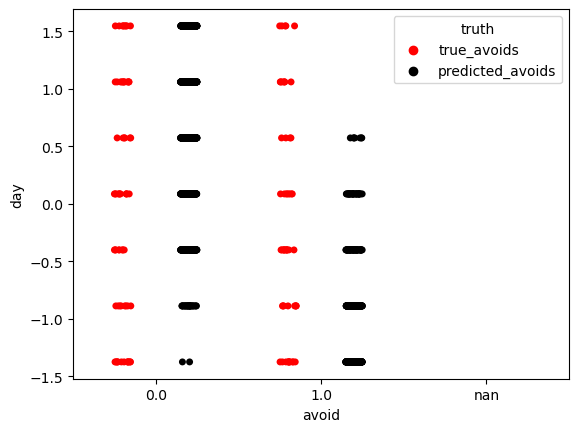

In [142]:
predictions = model.predict(X_test_processed)
labels = np.where(predictions > 0.5, 1, 0)
all_test_data = X_test_df.assign(true_avoids = y_test,
                              predicted_avoids = labels)
selected_data = all_test_data.melt(
    id_vars = all_test_data.drop(columns = ['true_avoids', 'predicted_avoids']).columns,
     value_vars = ['true_avoids', 'predicted_avoids'], 
     value_name = 'avoid',
     var_name = 'truth')

sns.stripplot(data = selected_data, 
              x = 'avoid', 
              y = 'day', 
              jitter = True, 
              dodge = True,
              hue = 'truth', 
              palette = ['red', 'black'])

<Axes: xlabel='avoid', ylabel='trial_count'>

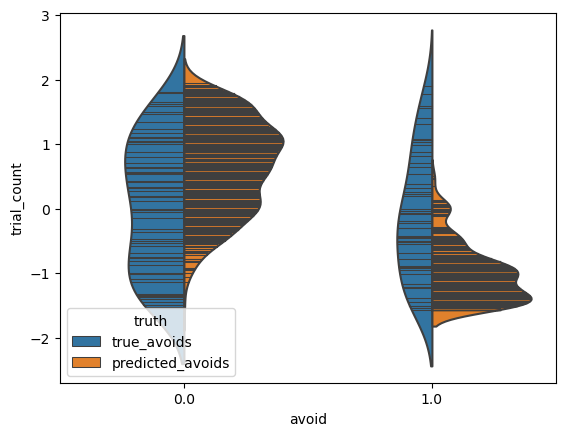

In [143]:
sns.violinplot(data = selected_data, 
              x = 'avoid', 
              y = 'trial_count',
              inner = 'stick',
              split = True,
              hue = 'truth',
              alpha = 0.5)
